# What factors predict S&P500?
We focus on currencies. Do currency exchange rates contain information that can predict S&P500 returns? To predict, we use three machine learning models:

- Support Vector Machine
- Decision Tree Classifier
- Random Forest Classifier

We simulate different variations of how the models could be set set up to ultimately decide what 1) what model is the best one and 2) what factors potentially have the power to predict SP500 returns.

In [1]:
#Import needed packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import random
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from itertools import combinations
from datetime import datetime

#Import model and visualization functions
import sys 
sys.path.append('../../src/models')
sys.path.append('../../src/visualization')
sys.path.append('../../src/data')
from support_vector_machine import support_vector_machine
from randomforest_classifier import randomforest_classifier
from decision_tree_classifier import decision_tree_classifier
from plot_results import plot_results
from combine_tables import combine_tables
from plot_simulation_results import plot_simulation_results
from run_simulations import run_simulations

#Import our data
log_returns_currencies = pd.read_csv("../../data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("../../data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe)

            DATE   USDEUR   USDJPY   USDGBP   USDCHF   USDAUD   USDCAD  \
0     2000-01-04 -0.01505 -0.01358 -0.00613  0.01549  0.00441 -0.00366   
1     2000-01-05 -0.00252 -0.00657 -0.00275  0.00251  0.00183  0.00000   
2     2000-01-06  0.00106 -0.01359 -0.00365 -0.00090  0.00153 -0.00364   
3     2000-01-07  0.00291  0.00019  0.00554 -0.00533 -0.00122  0.00454   
4     2000-01-10  0.00409 -0.00105  0.00061 -0.00517 -0.00198 -0.00433   
...          ...      ...      ...      ...      ...      ...      ...   
5952  2023-11-17 -0.00258  0.00513 -0.00056  0.00135 -0.00463  0.00247   
5953  2023-11-20 -0.00605  0.01047 -0.00602  0.00327 -0.00965  0.00146   
5954  2023-11-21  0.00201  0.00257 -0.00279  0.00113 -0.00168  0.00219   
5955  2023-11-22  0.00477 -0.01203  0.00576 -0.00249  0.00504 -0.00314   
5956  2023-11-24 -0.00578  0.00067 -0.01061  0.00396 -0.00747  0.00914   

       USDNZD   USDSEK   USDSGD   USDNOK    SP500  
0     0.01072  0.00988  0.00169  0.00377 -0.03910  
1     0

In [2]:
# e.g. get description of the models: 
?support_vector_machine
?decision_tree_classifier
?randomforest_classifier

## Models
For our models, as mentioned above, we use Support Vector Machine, Decision Tree Classifier and Random Forest Classifier. The models are set up as functions in the src/models folder and imported here. As a short overview, we describe the three models here in short:

- Support vector machine (SVM): SVM finds a hyperplane that best separates the data into different classes. In a binary classification scenario, this hyperplane maximizes the margin between the two classes. SVM can also handle non-linear boundaries through the use of kernels.

- Decision Tree Classifier (DTC): The algorithm recursively splits the dataset based on features to create a tree-like structure. Each internal node represents a decision based on a feature, and each leaf node represents a class or a numerical value. Decision trees are interpretable and can capture non-linear relationships in the data.

- Random Forest Classifier (RFC): It constructs a forest of decision trees by training each tree on a random subset of the training data and using a random subset of features for each split. The final prediction is often a majority vote (classification) or an average (regression) of the individual tree predictions.

We tried to give the user as many possibilities regarding the model specification as possible. Therefore, the models are able to process countless different combinations of inputs. Hereafter, a short description of all model input parameters is given for every model. The same documentation can also be accessed by running "?functionname".

def support_vector_machine(dataframe, currencies=None, include_sp500=True,lag=1, train_size=0.75, seed=42, long_only=False):
   - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally a 'SP500' column.
   - currencies (list of str, optional): A list of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
   - include_sp500 (bool): Determines whether to include information from the S&P 500 data in the analysis. Defaults to True.
   - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
   - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
   - seed (int): The seed can be set manually such that the results are reproducible. Default is 42.
   - long_only (bool): If true, the model can only go long, otherwise it can go long and short.

def decision_tree_classifier(dataframe, currencies=None, include_sp500=True, lag=1, train_size=0.75, seed=42, long_only=False, max_depth=10):
   - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally an 'SP500' column.
   - currencies (list of str, optional): List of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
   - include_sp500 (bool): Determines whether to include the S&P 500 data in the analysis. Defaults to True.
   - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
   - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
   - seed (int): The seed can be set manually such that the results are reproducible. Default is 42.
   - long_only (bool): If true, the model can only go long, otherwise it can go long and short.
   - max_depth (int): The maximum depth of the decision tree. Helps to control the complexity of the model. Defaults to 10.
   
def randomforest_classifier(dataframe, currencies=None, include_sp500=True, lag=1, train_size=0.75, seed=42, long_only=False, trees=30, max_depth=10, leaves=10):
   - dataframe (pd.DataFrame): The dataset containing the financial data. It should have a 'DATE' column, currency data columns, and optionally an 'SP500' column.
   - currencies (list of str, optional): List of currency columns to include in the analysis. If None, all available currencies in the dataframe will be used.
   - include_sp500 (bool): Determines whether to include the S&P 500 data in the analysis. Defaults to True.
   - lag (int): The number of periods by which to lag the response variable for prediction. Defaults to 1.
   - train_size (float): The proportion of the dataset to use for training the model. The rest will be used for testing. Defaults to 0.75.
   - seed (int): The seed can be set manually such that the results are reproducible. Default is 42.
   - long_only (bool): If true, the model can only go long, otherwise it can go long and short.
   - trees (int): The number of trees in the forest. More trees can lead to a more robust and stable model, but it also comes with increased computational cost. Default is 30.
   - max_depth (int): The maximum depth of one decision tree in the forest. Helps to control the complexity of the model. Defaults to 10.
   - leaves (int): The maximum number of terminal nodes / leaves in one tree. Helps to control the complexity of the model. Defaults to 10.

In [3]:
#Select the number of days lag for our models
lag = 1
#Select the size of the training dataset (%)
train_size = 0.8
#Set a seed
seed = 42
#Specify which currencies to use in the analysis
currencies = ['USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD', 
              'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK']
#Choose whether S&P 500 should be used as a regressor variable
include_sp500 = False
#Should the strategy be long only?
long_only = False
#Number of Simulations?
num_simulations = 100

In [4]:
#Train the models and print their accuracies
svm_accuracies, svm_results = support_vector_machine(dataframe, currencies, include_sp500, lag, train_size, 2, long_only)

In [5]:
dt_accuracies, dt_results = decision_tree_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only)

In [6]:
rf_accuracies, rf_results = randomforest_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only)

In [7]:
result_table = pd.concat([svm_accuracies, dt_accuracies, rf_accuracies], ignore_index=False)
result_table

,in sample,out of sample
Classifiers,,
SVC,0.581024,0.510906
DTC,0.624265,0.477349
RFC,0.564442,0.510067


### Plot these results

In [8]:
results = combine_tables([svm_results, dt_results, rf_results])
results['DATE'] = pd.to_datetime(results['DATE'], format='%Y-%m-%d')

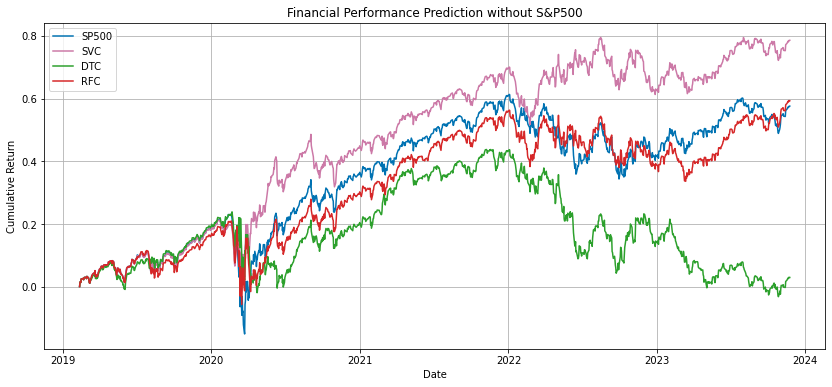

In [9]:
plot_results(results, include_sp500)

In [12]:
?randomforest_classifier

Signature:      
randomforest_classifier(
    dataframe,
    currencies=None,
    include_sp500=True,
    lag=1,
    train_size=0.75,
    seed=42,
    long_only=False,
    trees=30,
    max_depth=10,
    leaves=10,
)
Call signature:  randomforest_classifier(*args, **kwargs)
Type:            MemorizedFunc
String form:     MemorizedFunc(func=<function randomforest_classifier at 0x7f037f875bd0>, location=../../data/cache/joblib)
File:            ~/projects/what_factors_predict_sp500/src/models/randomforest_classifier.py
Docstring:      
Memoized version of randomforest_classifier(dataframe, currencies=None, include_sp500=True, lag=1, train_size=0.75, seed=42, long_only=False, trees=30, max_depth=10, leaves=10)

Trains a Randomforest Classifier on financial data to predict binary outcomes and evaluates its performance.

This function processes financial data, which can include currency pairs and optionally S&P 500 data, and applies a Decision Tree Classifier for binary classification. It c

MovieWriter imagemagick unavailable; using Pillow instead.


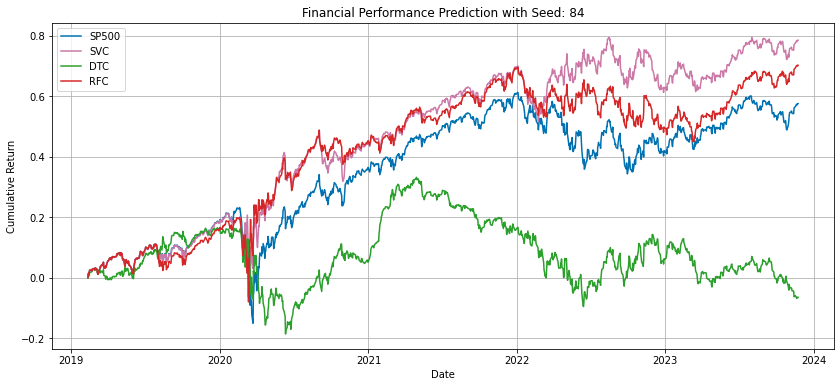

In [13]:
# Number of iterations (different random seeds)
num_iterations = 20

# Create a figure
fig, ax = plt.subplots(figsize=(14, 6))
# Replace this with your actual function
def function_to_update(seed):
    svm_accuracies, svm_results = support_vector_machine(dataframe, currencies, include_sp500, lag, train_size, seed, long_only)
    dt_accuracies, dt_results = decision_tree_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only, 15)
    rf_accuracies, rf_results = randomforest_classifier(dataframe, currencies, include_sp500, lag, train_size, seed, long_only, 30, 15, 10)
    results = combine_tables([svm_results, dt_results, rf_results])
    results['DATE'] = pd.to_datetime(results['DATE'], format='%Y-%m-%d')
    # starting from here is reused from the function: plot_results
    cols = results.shape[1]
    # Set the Seaborn color palette
    color_palette = {
        'SP500': (0.0, 0.4470588235294118, 0.6980392156862745),  # Blue
        'DTC': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),  # Green
        'RFC': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),  # Red
        'SVC': (0.8, 0.4745098039215686, 0.6549019607843137)  # Orange
    }

    # Use the custom color palette
    for i in range(1, cols):
        col_title = results.columns[i]
        ax.plot(results["DATE"], results.iloc[:, i], label=col_title, color=color_palette.get(col_title, 'k'))  # 'k' is black for any undefined column title

    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.title(f"Financial Performance Prediction with Seed: {seed}")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)

def update(frame):
    ax.clear()
    seed = random.randint(0, 1000)
    function_to_update(seed)

# Create the animation
animation = FuncAnimation(fig, update, frames=num_iterations, repeat=False)

# Save the animation as a GIF file
animation.save('../../reports/figures/financial_performance_animation.gif', writer='imagemagick')

# Display the animation in the notebook
HTML(animation.to_jshtml())

## Simulate the results
### Function: run_simulations
This function serves as the core of the simulation process. It accepts various parameters to customize the simulations, including the dataset, selected currencies, SP500 inclusion, lag time, training dataset size, and the choice to focus on long-only strategies. The function also determines the number of simulations to run.

- Initialization: The function initializes three pandas DataFrames to store results from each model.

- Simulation Loop: For each simulation iteration, the function:
    - Generates a random seed for reproducibility.
    - Runs simulations for each of the three models (SVM, RFC, DTC), each time storing the relevant results.
    
- Result Aggregation: It aggregates results from each model. For the first iteration, it extracts and stores date and SP500 data. For subsequent iterations, it appends the last column of the simulation results, representing the simulation's specific outcome.

- Date Formatting: Finally, the function converts the 'DATE' columns in the results to Python datetime objects for easier manipulation later.

### Function: plot_simulation_results
After running the simulations, this function comes into play, visualizing the results for each model.

- Quantile Calculations: For the RFC and DTC models, it calculates the 25th, 50th (median), and 75th quantiles for the last simulation's results.

- Plotting SVM Results: It plots the SVM simulation results against the SP500 data. The plot visualizes how the SVM model's predictions compare to the actual SP500 performance over time.
    
- Plotting RFC Results: This step involves plotting the RFC simulations with a focus on quantiles. It shows the range (25th to 75th quantile) and median predictions, providing a visual representation of the model's prediction distribution. It also plots the SP500 performance over that period of time.

- Plotting DTC Results: Similar to RFC, it plots the DTC simulations highlighting the quantiles and the S&P500 performance over that period of time. This visualization helps in understanding the spread and central tendency of the DTC model's predictions.

In [22]:
svm_results, rf_results, dt_results = run_simulations(dataframe, currencies, include_sp500, lag, train_size, long_only, num_simulations)

NameError: name 'pd' is not defined

In [16]:
plot_simulation_results(svm_results, rf_results, dt_results)

/home/alex/projects/what_factors_predict_sp500/notebooks/../src/visualization/plot_simulation_results.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)
/home/alex/projects/what_factors_predict_sp500/notebooks/../src/visualization/plot_simulation_results.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ranges.rename(columns={lq_column:'25% quantile',median_column:'median',hq_column:'75% quantile'},inplace=True)


NameError: name 'sns' is not defined

<Figure size 1400x600 with 0 Axes>

Functions need to be redefined (random_seed) for all three models. As one can see, the results look completely random. Check look ahead bias. What is compared to what in the model? How is the lag introduced? Doesnt make sense now.
Run a simulation where the seed is drawed randomly. Get averages (in-sample error, out of sample error), show average performance. For randomforest and decisiontree, we could also do hyperparameter training (split data in training, validation and test sets). Make different plots from the output of the model.

## Find "Best predictor"
Based on our models, we try in a further analysis to find the "best predictor". In this section, we take the SVM model and run it using different currencies as input, to try and find in what setting we get the best results.

In [14]:
#Select the number of days lag for our models
lag = 1
#Select the size of the training dataset (%)
train_size = 0.8
#Set a seed
seed = 42
#Specify which currencies to use in the analysis
currencies = ['USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD', 
              'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK']
#Choose whether S&P 500 should be used as a regressor variable
include_sp500 = False
#Should the strategy be long only?
long_only = False

In [48]:
?support_vector_machine

In [15]:
# Create empty DataFrames to store accuracies and results
accuracies_df = pd.DataFrame(columns=['Combination', 'In-Sample', 'Out-of-Sample'])
results_df = pd.DataFrame()

# Iterate over every combination of two or more currencies
for r in range(1, len(currencies) + 1):
    for combination in combinations(currencies, r):
        # Convert combination to a string for naming purposes
        combination_str = '_'.join(combination)

        # Call your SVM function with the current combination
        svm_accuracies, svm_results = support_vector_machine(dataframe, list(combination), include_sp500, lag, train_size,0, long_only)

        # Save accuracies
        new_row = pd.DataFrame({'Combination': [combination_str],
                                'In-Sample': [svm_accuracies.iloc[0]['in sample']],
                                'Out-of-Sample': [svm_accuracies.iloc[0]['out of sample']]})
        accuracies_df = pd.concat([accuracies_df, new_row], ignore_index=True)

        # Save results
        svm_results.rename(columns={'SVC': f'SVC_{combination_str}'}, inplace=True)
        if results_df.empty:
            results_df = svm_results
        else:
            results_df = pd.merge(results_df, svm_results, on=['DATE', 'SP500'], how='outer')


In [16]:
accuracies_df['Combination'] = accuracies_df['Combination'].str.split('_').apply(lambda x: ', '.join([currency[3:] for currency in x]))
accuracies_df

,Combination,In-Sample,Out-of-Sample
0,EUR,0.536104,0.526007
1,JPY,0.535474,0.532718
2,GBP,0.533795,0.535235
3,CHF,0.535474,0.531879
4,AUD,0.535264,0.535235
...,...,...,...
1018,"EUR, JPY, GBP, AUD, CAD, NZD, SEK, SGD, NOK",0.577036,0.512584
1019,"EUR, JPY, CHF, AUD, CAD, NZD, SEK, SGD, NOK",0.571788,0.518456
1020,"EUR, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK",0.574097,0.515101
1021,"JPY, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK",0.578086,0.509228


In [40]:
new_columns = ['DATE', 'SP500'] + [', '.join(currency[3:] for currency in column.split('_')[1:]) for column in results_df.columns[2:]]
new_columns
results_df.columns = new_columns
results_df

,DATE,SP500,EUR,JPY,GBP,CHF,AUD,CAD,NZD,SEK,...,"EUR, JPY, GBP, CHF, AUD, CAD, NZD, SEK, NOK","EUR, JPY, GBP, CHF, AUD, CAD, NZD, SGD, NOK","EUR, JPY, GBP, CHF, AUD, CAD, SEK, SGD, NOK","EUR, JPY, GBP, CHF, AUD, NZD, SEK, SGD, NOK","EUR, JPY, GBP, CHF, CAD, NZD, SEK, SGD, NOK","EUR, JPY, GBP, AUD, CAD, NZD, SEK, SGD, NOK","EUR, JPY, CHF, AUD, CAD, NZD, SEK, SGD, NOK","EUR, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK","JPY, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK","EUR, JPY, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK"
0,2019-02-11,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,...,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710
1,2019-02-12,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,...,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603
2,2019-02-13,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,...,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627
3,2019-02-14,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,...,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971
4,2019-02-15,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,...,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2023-11-17,0.565987,0.508816,0.560552,0.565987,0.511407,0.565987,0.703753,0.614112,0.565987,...,0.669866,0.838340,0.440863,0.566337,0.444497,0.609045,0.670199,0.637544,0.415336,0.775730
1188,2023-11-20,0.573374,0.516204,0.567939,0.573374,0.518794,0.573374,0.711140,0.621499,0.573374,...,0.677253,0.845727,0.448250,0.573725,0.451885,0.616432,0.677587,0.644931,0.422723,0.783117
1189,2023-11-21,0.571356,0.514186,0.565921,0.571356,0.516776,0.571356,0.709122,0.619481,0.571356,...,0.675235,0.843709,0.446232,0.571707,0.449867,0.614414,0.675569,0.642913,0.420705,0.781099
1190,2023-11-22,0.575414,0.518244,0.569980,0.575414,0.520834,0.575414,0.713180,0.623539,0.575414,...,0.679293,0.847768,0.450290,0.575765,0.453925,0.618472,0.679627,0.646971,0.424763,0.785157


In [41]:
# Save DataFrames to files or use them as needed
accuracies_df.to_csv('../Data/processed/svm_accuracies_merged.csv', index=False)
results_df.to_csv('../Data/processed/svm_results_merged.csv', index=False)

In [46]:
file_path = '../Data/processed/svm_accuracies_merged.csv'
accuracies_df = pd.read_csv(file_path)
file_path1 = '../Data/processed/svm_results_merged.csv'
results_df = pd.read_csv(file_path1)

In [47]:
print(accuracies_df)
print(results_df)

                                           Combination  In-Sample  \
0                                                  EUR   0.536104   
1                                                  JPY   0.535474   
2                                                  GBP   0.533795   
3                                                  CHF   0.535474   
4                                                  AUD   0.535264   
...                                                ...        ...   
1018       EUR, JPY, GBP, AUD, CAD, NZD, SEK, SGD, NOK   0.577036   
1019       EUR, JPY, CHF, AUD, CAD, NZD, SEK, SGD, NOK   0.571788   
1020       EUR, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK   0.574097   
1021       JPY, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK   0.578086   
1022  EUR, JPY, GBP, CHF, AUD, CAD, NZD, SEK, SGD, NOK   0.581024   

      Out-of-Sample  
0          0.526007  
1          0.532718  
2          0.535235  
3          0.531879  
4          0.535235  
...             ...  
1018       0.5125

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


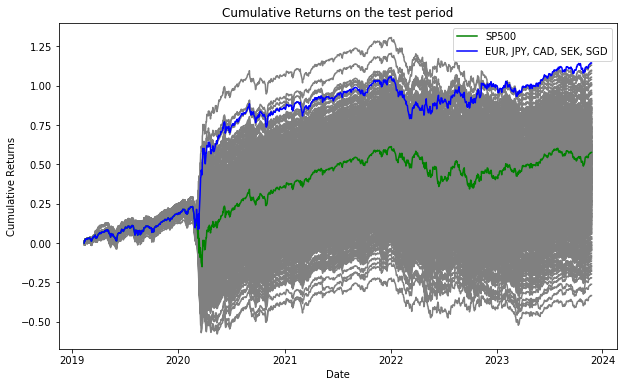

In [114]:
data = results_df
#Extracting dates
dates = pd.to_datetime(data['DATE'])

# Extracting values for each line
sp500_values = data['SP500']
svc_values = data.drop(['DATE', 'SP500'], axis=1)

# Find the column with the best end value
best_column = svc_values.iloc[-1].idxmax()

# Plotting
plt.figure(figsize=(10, 6))

# Plot other lines in grey
for column in svc_values.columns:
    if column != best_column:
        plt.plot(dates, svc_values[column], color='grey')

# Plot SP500 as a green line
plt.plot(dates, sp500_values, color='(0.0, 0.4470588235294118, 0.6980392156862745)', label='SP500')

# Plot the best line in blue
plt.plot(dates, svc_values[best_column], color='red', label=best_column)

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns on the test period')

# Show the plot
plt.show()

In [116]:
results_df[best_column]

0       0.000710
1       0.013603
2       0.016627
3       0.013971
4       0.024849
          ...   
1187    1.134105
1188    1.141492
1189    1.139474
1190    1.143533
1191    1.144133
Name: EUR, JPY, CAD, SEK, SGD, Length: 1192, dtype: float64

Looks really random, and one can see the scissor opening up when the daily returns blew up during COVID 2020. Having been short there lead to big returns already.

In [65]:
# Assuming the 'DATE' and 'SP500' columns are the first two columns
date_sp500_cols = results_df.columns[:2]

# Select the last row of the DataFrame
last_row = results_df.iloc[-1]

x = 25 #how many top elements

# Exclude 'DATE' and 'SP500' columns and get the 10 columns with the highest end values
selected_columns = last_row.drop(date_sp500_cols).sort_values(ascending=False).head(x).index

# Define the desired order of columns
desired_columns_order = ['DATE', 'SP500'] + selected_columns.tolist()

# Extract the ordered columns
top_x = results_df[desired_columns_order]
#top_x

,DATE,SP500,"EUR, JPY, CAD, SEK, SGD","EUR, JPY, CAD, SEK","EUR, JPY, GBP, CAD, SEK","GBP, CHF, AUD, NZD","EUR, GBP, AUD","EUR, CAD, NZD, SEK, SGD","EUR, CHF, AUD, NZD, NOK","EUR, CHF, AUD, NZD, SEK, NOK",...,"EUR, CHF, AUD, NZD, SEK","EUR, JPY, CHF, CAD, SGD, NOK","EUR, JPY, SEK","EUR, JPY, NZD, SEK","EUR, GBP, CHF, AUD, NZD","JPY, CHF, SEK, NOK","JPY, CAD, SEK, SGD","EUR, JPY, AUD, NZD, SEK","EUR, CHF, NZD, NOK","GBP, AUD, CAD, NZD, SGD"
0,2019-02-11,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,...,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710,0.000710
1,2019-02-12,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,...,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603,0.013603
2,2019-02-13,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,...,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627,0.016627
3,2019-02-14,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,...,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971,0.013971
4,2019-02-15,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,...,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849,0.024849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2023-11-17,0.565987,1.134105,1.120272,1.087636,1.083743,1.068939,1.043939,1.029424,1.007636,...,0.939220,0.937538,0.934109,0.907619,0.906720,0.899539,0.897295,0.895176,0.893163,0.892916
1188,2023-11-20,0.573374,1.141492,1.127659,1.095023,1.091131,1.076326,1.051326,1.036811,1.015023,...,0.946608,0.944925,0.941496,0.915007,0.914107,0.906926,0.904682,0.902563,0.900550,0.900304
1189,2023-11-21,0.571356,1.139474,1.125641,1.093005,1.089113,1.074308,1.049308,1.034793,1.013005,...,0.944590,0.942907,0.939478,0.912989,0.912089,0.904908,0.902664,0.900545,0.898532,0.898286
1190,2023-11-22,0.575414,1.143533,1.129699,1.097064,1.093171,1.078367,1.053366,1.038851,1.017063,...,0.948648,0.946965,0.943536,0.917047,0.916147,0.908967,0.906722,0.904603,0.902590,0.902344


In [67]:
filtered_accuracies = accuracies_df[accuracies_df['Combination'].isin(selected_columns)]
# Display the filtered DataFrame
print(filtered_accuracies)
print(accuracies_df.mean())

                           Combination  In-Sample  Out-of-Sample
60                       EUR, JPY, SEK   0.545970       0.515101
64                       EUR, GBP, AUD   0.549748       0.523490
116                      JPY, SEK, SGD   0.549538       0.518456
194                 EUR, JPY, CAD, SEK   0.555835       0.505034
197                 EUR, JPY, NZD, SEK   0.561503       0.505034
235                 EUR, CHF, NZD, NOK   0.549748       0.520973
293                 JPY, CHF, SEK, NOK   0.551427       0.521812
308                 JPY, CAD, SEK, SGD   0.557095       0.510067
316                 GBP, CHF, AUD, NZD   0.551008       0.526846
397            EUR, JPY, GBP, CAD, SEK   0.565911       0.499161
425            EUR, JPY, AUD, NZD, SEK   0.562133       0.515101
431            EUR, JPY, CAD, NZD, SEK   0.565281       0.496644
434            EUR, JPY, CAD, SEK, SGD   0.561713       0.510906
442            EUR, GBP, CHF, AUD, NZD   0.556255       0.526846
480            EUR, CHF, 

In [76]:
# Assuming the column with the currency combinations is named "Currencies"
currencies_column = 'Combination'

# Split the values in the "Currencies" column and create a list of all currencies
all_currencies = [currency.strip() for currencies in filtered_accuracies[currencies_column] for currency in currencies.split(',')]

# Create a DataFrame to count the occurrences of each currency
currency_counts = pd.DataFrame(all_currencies, columns=['Combination']).groupby('Combination').size().reset_index(name='Count')
currency_counts = currency_counts.sort_values(by='Count', ascending=False)
currency_counts = currency_counts.reset_index(drop=True)
print(currency_counts)


  Combination  Count
0         EUR     20
1         NZD     16
2         SEK     15
3         CAD     13
4         JPY     12
5         CHF     11
6         AUD      9
7         NOK      8
8         SGD      8
9         GBP      7


In [101]:
# Get columns where 'EUR' is present in the column name
eur_columns = [col for col in results_df.columns if 'EUR' in col]

# Create a new DataFrame with the selected columns
eur_data = results_df[['DATE', 'SP500'] + eur_columns]

# Display the resulting DataFrame
#print(eur_data)
# Get the values in the last row of the last column
last_row_values = eur_data.iloc[-1][2:]
# Calculate the mean of the last row values
print('Average cumulative return of predictions with EUR: ', last_row_values.mean())
print('Cumulative return of SP500: ', eur_data.iloc[-1][2])
rel_exret = last_row_values.mean()/eur_data.iloc[-1][2] -1
print('Excess return: ', rel_exret)
print(eur_data['DATE'].iloc[-1])
diffdays = datetime.strptime(eur_data['DATE'].iloc[-1], '%Y-%m-%d') - datetime.strptime(eur_data['DATE'][0], '%Y-%m-%d')
diffdays = diffdays.days
diffyears = diffdays / 365.25
rel_exret**(1/diffyears)

Average cumulative return of predictions with EUR:  0.534813470174471
Cumulative return of SP500:  0.5188439667064043
Excess return:  0.03077900966920799
2023-11-24


0.48298686739834645

Not a significant result. Only a small excess return, over a 4.7 year period, leading to only around 0.5% excess return p.a.
Including transaction costs, this excess return has been eaten up. Also, we enable the model to short the index, which would effectively lead to margin requirements.

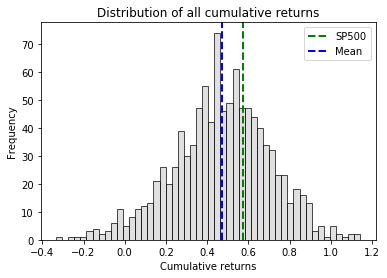

In [108]:
# Select the last row of the DataFrame
last_row = results_df.iloc[-1][2:]

# Get the SP500 value and mean value
sp500_value = results_df['SP500'].iloc[-1]
mean_value = last_row.mean()

# Create a histogram
plt.hist(last_row, bins=50, alpha=0.7, color='lightgrey', edgecolor='black')

# Add vertical lines for SP500 and mean
plt.axvline(x=sp500_value, color='green', linestyle='dashed', linewidth=2, label='SP500')
plt.axvline(x=mean_value, color='blue', linestyle='dashed', linewidth=2, label='Mean')

# Set labels and title
plt.xlabel('Cumulative returns')
plt.ylabel('Frequency')
plt.title('Distribution of all cumulative returns')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Further considerations
Fit model with not only a training set, but also a validation set, where the model hyperparameters are tested.


# Conclusion
After our analysis done, we can conclude that currency exchange rates do not contain information with significant predictive power.